<a href="https://colab.research.google.com/github/jocelync-invisible/icu-length-of-stay-prediction/blob/main/models/Bayesian_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import numpy as np
import pandas as pd
from google.colab import drive
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler,    # current scaler
    MinMaxScaler,      # Scales features to [0,1]
    RobustScaler,      # Uses median and quantiles - better with outliers
    QuantileTransformer,  # Makes uniform or normal distribution
    PowerTransformer   # Makes data more Gaussian
)
from sklearn.decomposition import PCA

In [68]:
tf.random.set_seed(42)
np.random.seed(42)

In [69]:
drive.mount('/content/drive')

shared_path = '/content/drive/MyDrive/AK_data_folder/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Import Data and Data Split

In [71]:
df = pd.read_csv(shared_path + 'mimiccomb_processed.csv')
# df = pd.read_csv('mimiccomb_processed (1).csv')
df.head()

,Unnamed: 0,subject_id,gender,anchor_age,hadm_id,insurance,marital_status,stay_id,los,org_name,positive_culture,microbio_group_comb,microbio_group_Unknown,microbio_group_fungi_yeasts,microbio_group_gram_negative_rods,microbio_group_gram_positive_cocci,microbio_group_gram_positive_rods,microbio_group_mixed_flora
0,8,10000032,0,52,29079034,1,0.0,39553978.0,0.410266,Unknown,0,Unknown,1,0,0,0,0,0
1,9,10000032,0,52,29079034,1,0.0,39553978.0,0.410266,Unknown,0,Unknown,1,0,0,0,0,0
2,10,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,Unknown,0,Unknown,1,0,0,0,0,0
3,11,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,Unknown,0,Unknown,1,0,0,0,0,0
4,12,10001217,0,55,24597018,0,1.0,37067082.0,1.118032,FUSOBACTERIUM NUCLEATUM,1,gram_negative_rods,0,0,1,0,0,0


In [72]:
df.describe()

,Unnamed: 0,subject_id,gender,anchor_age,hadm_id,insurance,stay_id,los,positive_culture,microbio_group_Unknown,microbio_group_fungi_yeasts,microbio_group_gram_negative_rods,microbio_group_gram_positive_cocci,microbio_group_gram_positive_rods,microbio_group_mixed_flora
count,2731.000000,2.731000e+03,2731.000000,2731.000000,2.731000e+03,2731.000000,2.731000e+03,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000
mean,837.187843,4.876835e+06,0.567192,61.659099,1.259932e+07,0.609301,1.719020e+07,6.423132,0.504211,0.541926,0.024167,0.293299,0.128891,0.006591,0.005126
std,506.230184,4.994259e+06,0.495555,15.174004,1.297735e+07,0.487996,1.755749e+07,6.795560,0.500074,0.498330,0.153595,0.455358,0.335140,0.080932,0.071428
min,0.000000,1.000600e+04,0.000000,17.000000,1.003750e+05,0.000000,2.012040e+05,0.155949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,392.500000,4.031000e+04,0.000000,53.000000,1.552970e+05,0.000000,2.476860e+05,1.644400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,850.000000,4.421200e+04,1.000000,62.000000,1.976110e+05,1.000000,2.910670e+05,3.385700,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1235.000000,1.002074e+07,1.000000,73.500000,2.580988e+07,1.000000,3.504434e+07,8.836470,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1958.000000,1.004002e+07,1.000000,91.000000,2.997458e+07,1.000000,3.988077e+07,31.123500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
df["marital_status"].isna().sum()

59

In [74]:
df = df.dropna(subset=["marital_status"])

In [75]:
# Drop unnecessary columns
df.drop(columns=['subject_id','hadm_id','stay_id','positive_culture','microbio_group_comb','org_name', 'Unnamed: 0'], inplace=True, errors='ignore')

In [76]:
df=df.query("marital_status!='Unknown' & marital_status.notnull()")

In [77]:
age_data = df[['anchor_age']]
los = df[['los']]
# Create a scaler (StandardScaler in this case)
age_scaler = StandardScaler()
los_scaler = StandardScaler()

# Fit and transform the scaler on the 'anchor_age' data
age_scaled = age_scaler.fit_transform(age_data)
los_scaled = los_scaler.fit_transform(los)

# Replace the original 'anchor_age' column in the DataFrame with the scaled values
df['anchor_age'] = age_scaled
df['los'] = los_scaled

In [78]:
df.describe()

,gender,anchor_age,insurance,los,microbio_group_Unknown,microbio_group_fungi_yeasts,microbio_group_gram_negative_rods,microbio_group_gram_positive_cocci,microbio_group_gram_positive_rods,microbio_group_mixed_flora
count,2507.000000,2.507000e+03,2507.000000,2.507000e+03,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000
mean,0.591943,-4.534776e-17,0.602314,3.401082e-17,0.535700,0.022337,0.307539,0.123255,0.006382,0.004787
std,0.491572,1.000200e+00,0.489518,1.000200e+00,0.498823,0.147808,0.461567,0.328795,0.079649,0.069033
min,0.000000,-2.955173e+00,0.000000,-9.305430e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-6.180463e-01,0.000000,-7.068150e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3.927063e-02,1.000000,-4.114018e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.965876e-01,1.000000,3.022073e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,2.157292e+00,1.000000,3.724168e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
X = df.drop(columns=['los'])
y = df['los']

In [80]:
X.shape

(2507, 10)

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2507 entries, 0 to 2730
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              2507 non-null   int64  
 1   anchor_age                          2507 non-null   float64
 2   insurance                           2507 non-null   int64  
 3   marital_status                      2507 non-null   object 
 4   microbio_group_Unknown              2507 non-null   int64  
 5   microbio_group_fungi_yeasts         2507 non-null   int64  
 6   microbio_group_gram_negative_rods   2507 non-null   int64  
 7   microbio_group_gram_positive_cocci  2507 non-null   int64  
 8   microbio_group_gram_positive_rods   2507 non-null   int64  
 9   microbio_group_mixed_flora          2507 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 215.4+ KB


In [82]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 2005 samples
Testing set size: 502 samples


# Train/Test Data Split

In [84]:
feature_names = [f"PCA Component {i+1}" for i in range(X_pca.shape[1])]

print('Train and test sizes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train and test sizes:
(2005, 6) (502, 6) (2005,) (502,)


In [85]:
print("Scaled LOS range - Train:", np.min(y_train), "to", np.max(y_train))
print("Scaled LOS range - Test:", np.min(y_test), "to", np.max(y_test))

Scaled LOS range - Train: -0.9305430353798657 to 3.724168281022018
Scaled LOS range - Test: -0.9305430353798657 to 3.724168281022018


In [86]:
y_mean, y_std = y_train.mean(), y_train.std()
y_train_scaled = y_train.copy()
y_test_scaled = y_test.copy()

# Model

In [108]:
def create_bnn_model(input_dims):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu',
                             kernel_initializer='he_normal', # prior belief
                             kernel_regularizer=tf.keras.regularizers.l2(0.0001), # prior belief
                             input_shape=(input_dims,)),
        tf.keras.layers.Dropout(0.2),  # MC Dropout for uncertainty estimation
        tf.keras.layers.Dense(16, activation='relu',
                             kernel_initializer='he_normal',
                             kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    return model

At 0.2, you're keeping 80% of the neurons active during each forward pass, which preserves enough information flow while still introducing sufficient randomness for Bayesian approximation.

In [105]:
model = create_bnn_model(X_train.shape[1])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mae'  # Mean Absolute Error: MAE is less sensitive to outliers.
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [106]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    min_lr=0.0001
)


# It watches the validation loss (monitor='val_loss')
# If it doesn't see improvement for 10 consecutive epochs (patience=10), it assumes the model is stuck near a local minimum
# It then reduces the learning rate by multiplying it by 0.3 (factor=0.3) - so if your learning rate was 0.01, it would become 0.003
# It won't reduce the learning rate below 0.0001 (min_lr=0.0001)


# Model Training

In [90]:
print("\nTraining the model...")
history = model.fit(
    X_train, y_train_scaled,
    epochs=300, #go through the entire training dataset 300 times
    batch_size=32, # common batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training the model...
Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7761 - val_loss: 0.6285 - learning_rate: 0.0100
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6473 - val_loss: 0.6112 - learning_rate: 0.0100
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6278 - val_loss: 0.5696 - learning_rate: 0.0100
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6131 - val_loss: 0.5205 - learning_rate: 0.0100
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5721 - val_loss: 0.5172 - learning_rate: 0.0100
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5576 - val_loss: 0.4968 - learning_rate: 0.0100
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5612 - val_loss: 0.4772 - learning_rate: 0.0100
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5429 - val_loss: 0.5017 - learning_rate: 0.0100
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5365 - val_loss: 0.4615 - learning_rate: 0.0

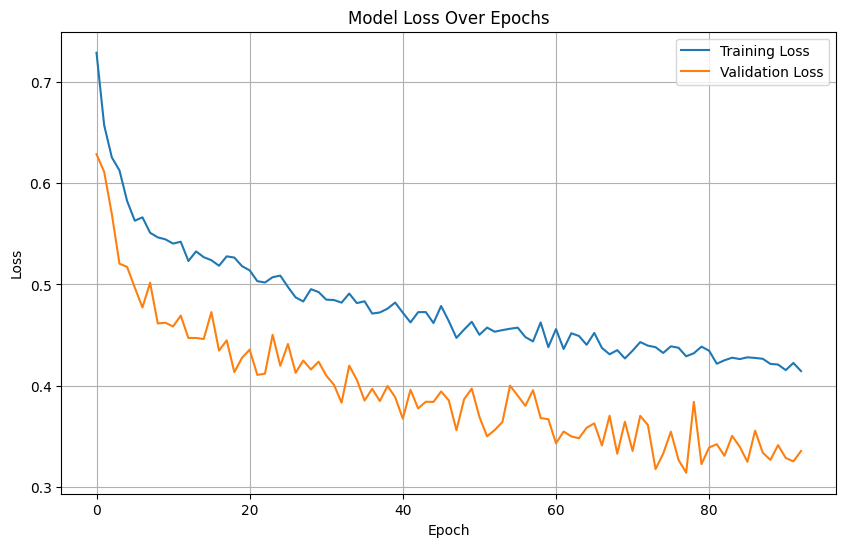

In [91]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
def predict_with_uncertainty(model, X, num_samples=100):
    predictions = []
    for _ in range(num_samples):
        y_pred = model(X, training=True)  # Enable dropout during inference
        predictions.append(y_pred)

    predictions = np.hstack(predictions)
    mean_prediction = np.mean(predictions, axis=1)
    std_prediction = np.std(predictions, axis=1)

    return mean_prediction, std_prediction

In a traditional neural network:

- Dropout (randomly setting 20% of neurons to zero) is only used during training
During inference/prediction, dropout is turned off completely

But in your Bayesian Neural Network:

- You're keeping dropout active during inference with training=True in your predict_with_uncertainty function
This is the key to making your regular neural network behave like a Bayesian model

In [93]:
# Make predictions on test set
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_pred_mean, y_pred_std = predict_with_uncertainty(model, X_test_tensor)

# Rescale predictions back to original scale (days)
y_pred_original = los_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).flatten()
y_pred_std_original = y_pred_std * los_scaler.scale_[0]  # Scale the uncertainty

# Get the original test values
y_test_original = los_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


# Analyse the results

In [94]:
# Calculate metrics on scaled data
mse = mean_squared_error(y_test, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_mean)
r2 = r2_score(y_test, y_pred_mean)

print(f"\nBayesian Neural Network Results (Scaled):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Bayesian Neural Network Results (Scaled):
MSE: 0.4156
RMSE: 0.6447
MAE: 0.3350
R-squared: 0.5848


In [95]:
# Calculate metrics on original scale
original_mse = mean_squared_error(y_test_original, y_pred_original)
original_rmse = np.sqrt(original_mse)
original_mae = mean_absolute_error(y_test_original, y_pred_original)
original_r2 = r2_score(y_test_original, y_pred_original)

print(f"\nBayesian Neural Network Results (Original Scale - Days):")
print(f"MSE: {original_mse:.4f}")
print(f"RMSE: {original_rmse:.4f} days")
print(f"MAE: {original_mae:.4f} days")
print(f"R-squared: {original_r2:.4f}")


Bayesian Neural Network Results (Original Scale - Days):
MSE: 18.3950
RMSE: 4.2889 days
MAE: 2.2285 days
R-squared: 0.5848


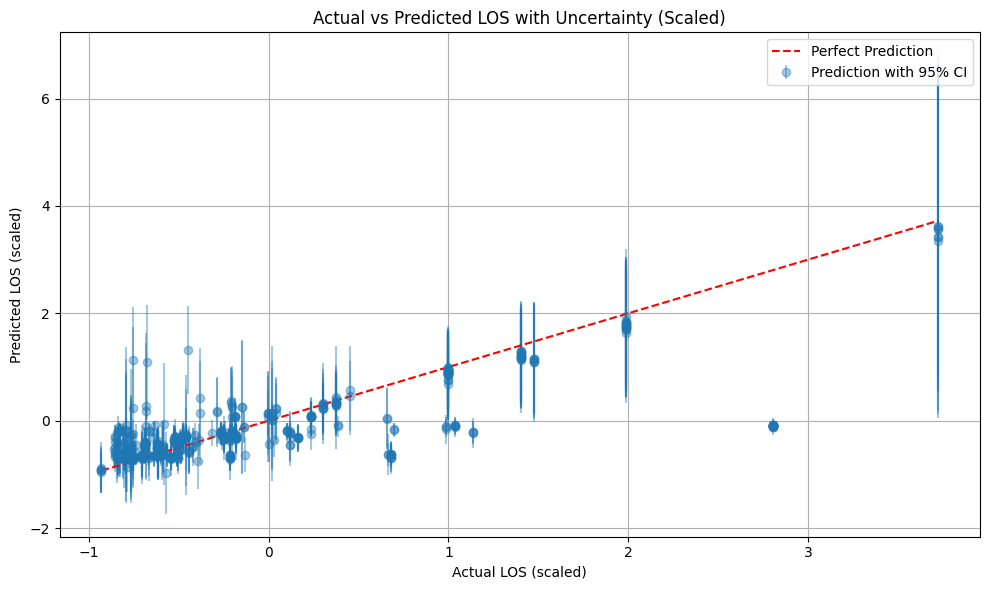

In [96]:
# Plot actual vs predicted with uncertainty (scaled data)
plt.figure(figsize=(10, 6))
plt.errorbar(y_test, y_pred_mean, yerr=1.96*y_pred_std, fmt='o', alpha=0.4, label='Prediction with 95% CI')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual LOS (scaled)')
plt.ylabel('Predicted LOS (scaled)')
plt.title('Actual vs Predicted LOS with Uncertainty (Scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

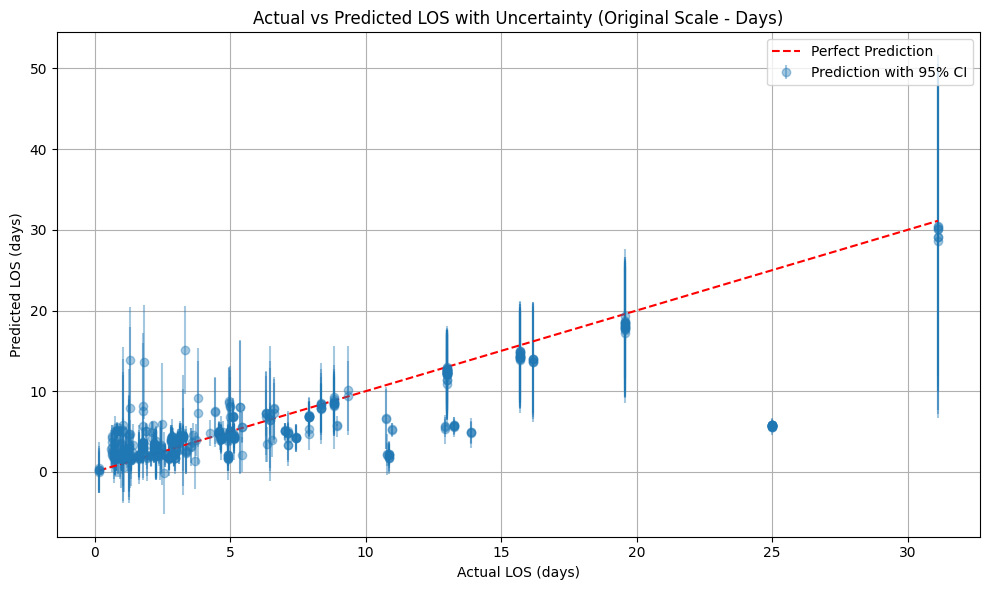

In [97]:
# Plot actual vs predicted with uncertainty (original scale - days)
plt.figure(figsize=(10, 6))
plt.errorbar(y_test_original, y_pred_original, yerr=1.96*y_pred_std_original, fmt='o', alpha=0.4, label='Prediction with 95% CI')
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual LOS (days)')
plt.ylabel('Predicted LOS (days)')
plt.title('Actual vs Predicted LOS with Uncertainty (Original Scale - Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

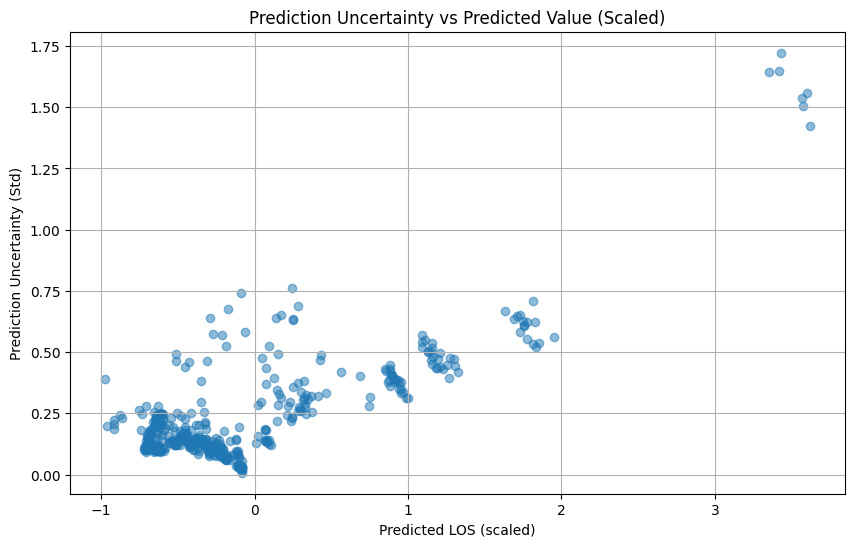

In [98]:
# Uncertainty analysis (scaled data)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_mean, y_pred_std, alpha=0.5)
plt.xlabel('Predicted LOS (scaled)')
plt.ylabel('Prediction Uncertainty (Std)')
plt.title('Prediction Uncertainty vs Predicted Value (Scaled)')
plt.grid(True)
plt.show()

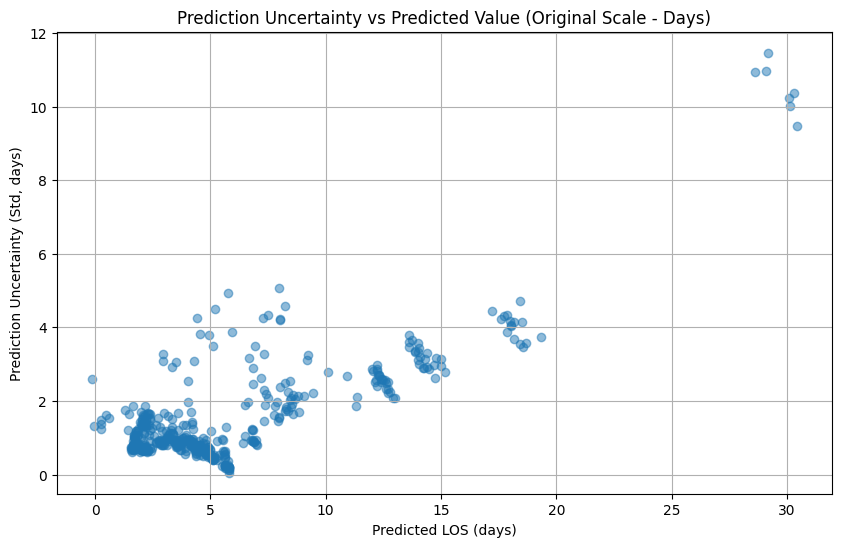

In [99]:
# Uncertainty analysis (original scale - days)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original, y_pred_std_original, alpha=0.5)
plt.xlabel('Predicted LOS (days)')
plt.ylabel('Prediction Uncertainty (Std, days)')
plt.title('Prediction Uncertainty vs Predicted Value (Original Scale - Days)')
plt.grid(True)
plt.show()

In [100]:
# Feature importance analysis using permutation importance
def calculate_feature_importance(model, X, y, num_repeats=10):
    baseline_score = r2_score(y, model.predict(X))
    importance = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(num_repeats):
            X_permuted = X.copy()
            X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
            y_pred = model.predict(X_permuted)
            score = r2_score(y, y_pred)
            scores.append(baseline_score - score)

        importance[i] = np.mean(scores)

    # Normalize importance scores
    importance = np.maximum(importance, 0)  # Replace negative values with 0
    if np.sum(importance) > 0:
        importance = importance / np.sum(importance)

    return importance

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1

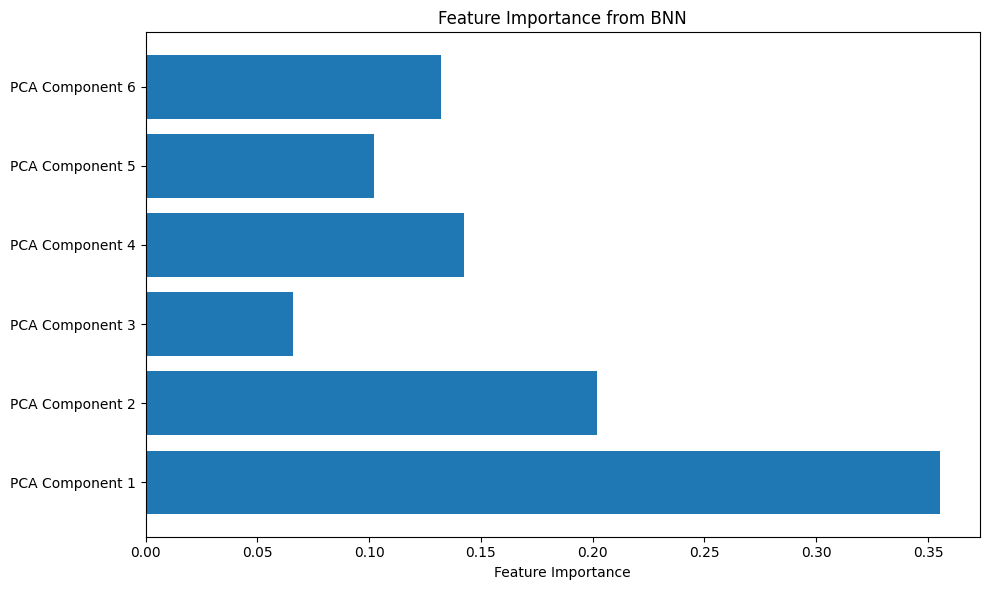

In [101]:
# We're using PCA components, so our feature names are PCA-based
feature_importance = calculate_feature_importance(model, X_test, y_test)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from BNN')
plt.tight_layout()
plt.show()

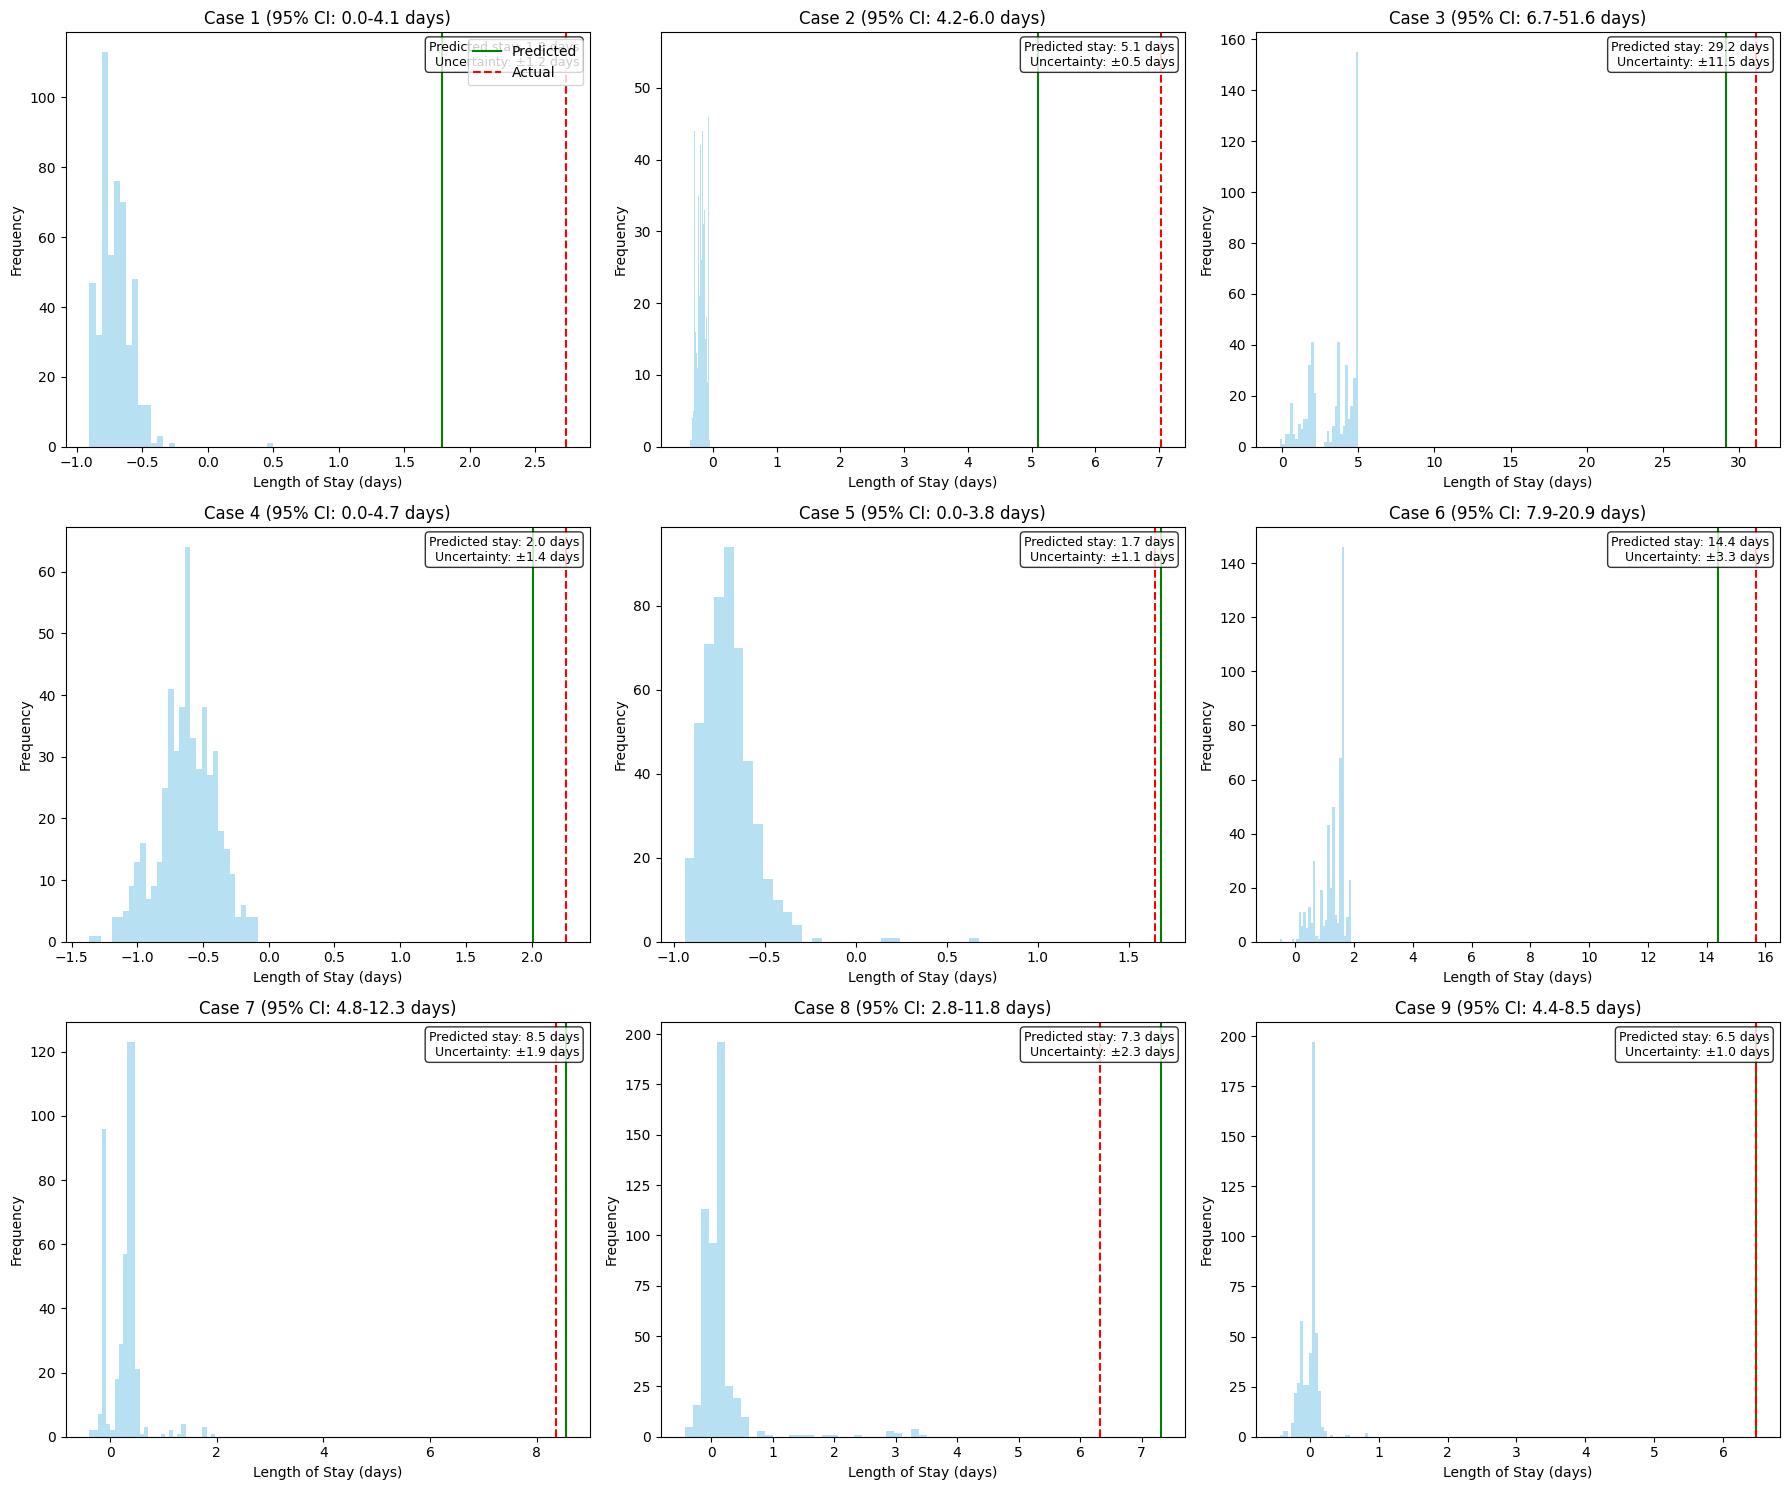

In [102]:
# Plot individual patient predictions with uncertainties
n_examples = min(9, len(y_test))  # Show up to 9 examples
n_rows = (n_examples + 2) // 3  # Calculate rows needed (3 plots per row)

plt.figure(figsize=(18, n_rows * 5))  # Adjust figure size based on number of rows

for i in range(n_examples):
    plt.subplot(n_rows, 3, i+1)

    # Generate multiple predictions using dropout
    samples = []
    for _ in range(500):
        sample = model(X_test_tensor[i:i+1], training=True).numpy()[0][0]
        samples.append(sample)

    # Plot histogram of predictions
    plt.hist(samples, bins=30, alpha=0.6, color='skyblue')

    # Add vertical line for predicted value (in original scale)
    plt.axvline(y_pred_original[i], color='g', linestyle='-', label='Predicted')

    # Add vertical line for actual value (in original scale)
    plt.axvline(y_test_original[i], color='r', linestyle='--', label='Actual')

    # Calculate 95% confidence interval (in original scale)
    ci_lower = y_pred_original[i] - 1.96 * y_pred_std_original[i]
    ci_upper = y_pred_original[i] + 1.96 * y_pred_std_original[i]

    # Simple patient details as title (with original scale values)
    plt.title(f"Case {i+1} (95% CI: {max(0, ci_lower):.1f}-{ci_upper:.1f} days)")

    if i == 0:
        plt.legend(loc='upper right')

    # Add prediction uncertainty metrics (in original scale)
    metrics_text = f"Predicted stay: {y_pred_original[i]:.1f} days\nUncertainty: ±{y_pred_std_original[i]:.1f} days"
    plt.text(0.98, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel('Length of Stay (days)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* Red dashed line: The actual observed length of stay (LOS) for that patient
* Green solid line: The model's predicted length of stay (the mean of the distribution)
* Blue histogram: The probability distribution of possible predictions, showing the model's uncertainty

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


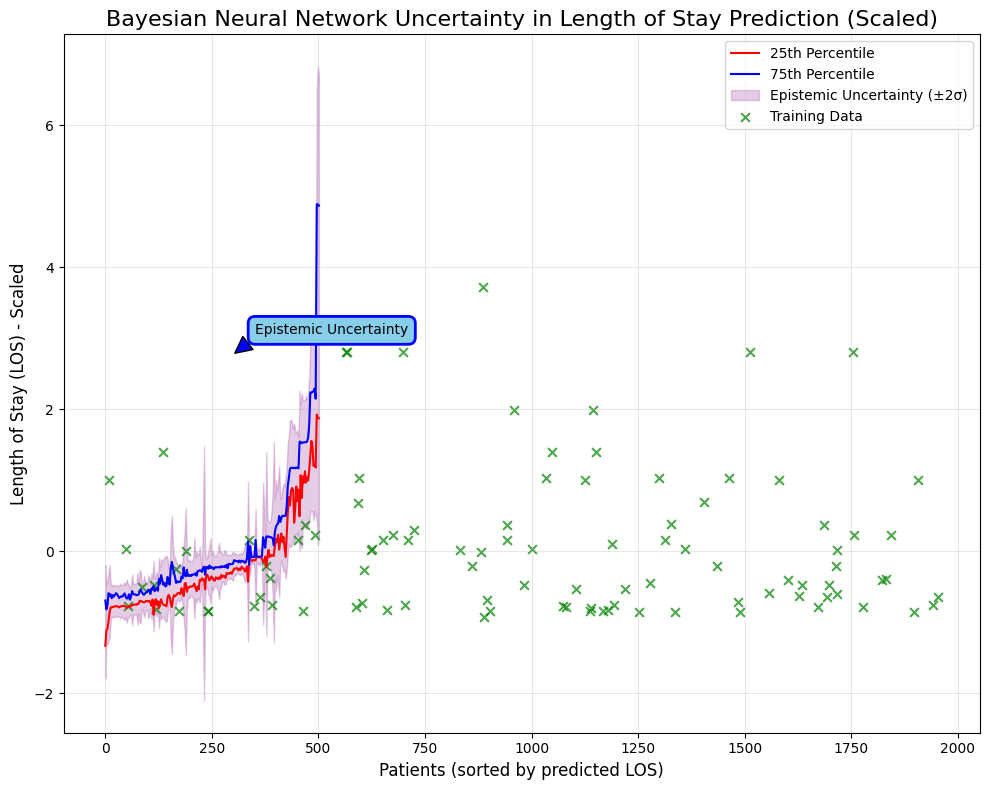

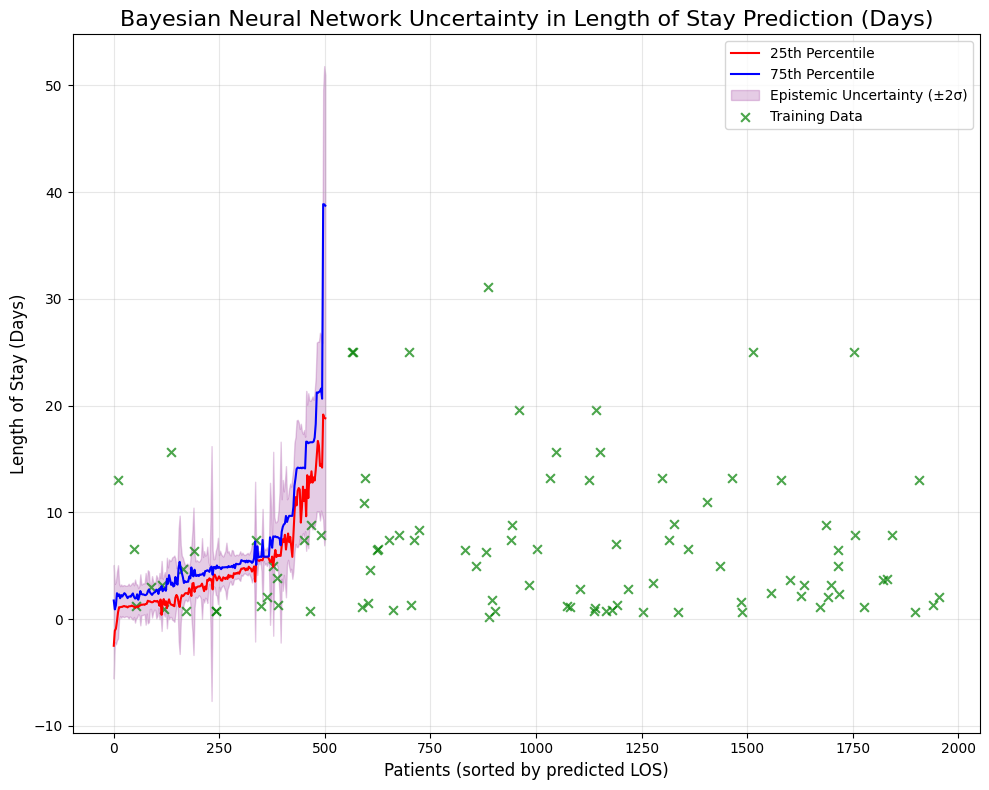

In [103]:
def plot_multidimensional_uncertainty(X_train, y_train, X_test, y_test, model, feature_names):
    from scipy.interpolate import make_interp_spline, interp1d

    # 1. First create the plot using scaled values
    # Sort test data by predicted LOS for smoother plotting
    y_pred = model.predict(X_test).flatten()
    sort_idx = np.argsort(y_pred)

    X_test_sorted = X_test[sort_idx]
    y_pred_sorted = y_pred[sort_idx]

    # Sample predictions with uncertainty
    num_samples = 100
    all_samples = []
    for _ in range(num_samples):
        samples = model(tf.convert_to_tensor(X_test_sorted, dtype=tf.float32),
                       training=True).numpy().flatten()
        all_samples.append(samples)

    samples_array = np.array(all_samples)

    # Calculate uncertainties
    epist_uncert = np.std(samples_array, axis=0)

    # Plot scaled values
    plt.figure(figsize=(10, 8))

    # Create a smooth curve for visualization
    x_indices = np.arange(len(y_pred_sorted))
    x_smooth = np.linspace(0, len(y_pred_sorted)-1, 200)

    # Choose interpolation method based on data size
    if len(y_pred_sorted) >= 4:  # Minimum points needed for cubic spline
        # Smooth the curves for plotting
        y_pred_smooth = make_interp_spline(x_indices, y_pred_sorted)(x_smooth)
        epist_smooth = make_interp_spline(x_indices, epist_uncert)(x_smooth)

        # Plot bootstrapped variants
        bootstrap1 = np.percentile(samples_array, 25, axis=0)
        bootstrap2 = np.percentile(samples_array, 75, axis=0)
        bootstrap1_smooth = make_interp_spline(x_indices, bootstrap1)(x_smooth)
        bootstrap2_smooth = make_interp_spline(x_indices, bootstrap2)(x_smooth)
    else:
        # Use simple linear interpolation for very small datasets
        y_pred_smooth = interp1d(x_indices, y_pred_sorted,
                                kind='linear', fill_value='extrapolate')(x_smooth)
        epist_smooth = interp1d(x_indices, epist_uncert,
                               kind='linear', fill_value='extrapolate')(x_smooth)

        bootstrap1 = np.percentile(samples_array, 25, axis=0)
        bootstrap2 = np.percentile(samples_array, 75, axis=0)
        bootstrap1_smooth = interp1d(x_indices, bootstrap1,
                                   kind='linear', fill_value='extrapolate')(x_smooth)
        bootstrap2_smooth = interp1d(x_indices, bootstrap2,
                                   kind='linear', fill_value='extrapolate')(x_smooth)

    # Plot model variants
    plt.plot(x_smooth, bootstrap1_smooth, 'r-', linewidth=1.5, label='25th Percentile')
    plt.plot(x_smooth, bootstrap2_smooth, 'b-', linewidth=1.5, label='75th Percentile')

    # Add uncertainty bands
    plt.fill_between(x_smooth,
                     y_pred_smooth - 2*epist_smooth,
                     y_pred_smooth + 2*epist_smooth,
                     color='purple', alpha=0.2, label='Epistemic Uncertainty (±2σ)')

    # Add some training data points
    # Sample a subset of training data for visibility
    train_indices = np.random.choice(len(y_train), size=min(100, len(y_train)), replace=False)
    y_train_sample = y_train.iloc[train_indices] if hasattr(y_train, 'iloc') else y_train[train_indices]
    plt.scatter(train_indices, y_train_sample, marker='x', color='green',
                alpha=0.7, s=40, label='Training Data')

    # Add annotations
    max_y = np.max(y_pred_smooth)
    annotation_y = max_y * 0.8

    plt.annotate('Epistemic Uncertainty',
                xy=(len(y_pred_sorted)*0.6, annotation_y),
                xytext=(len(y_pred_sorted)*0.7, annotation_y*1.1),
                arrowprops=dict(facecolor='blue', shrink=0.05),
                bbox=dict(boxstyle="round,pad=0.5", fc="skyblue", ec="b", lw=2))

    plt.legend(loc='upper right')
    plt.title('Bayesian Neural Network Uncertainty in Length of Stay Prediction (Scaled)', fontsize=16)
    plt.xlabel('Patients (sorted by predicted LOS)', fontsize=12)
    plt.ylabel('Length of Stay (LOS) - Scaled', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Now create the same plot using original scale values
    # Transform all predictions to original scale
    all_samples_original = []
    for sample_row in all_samples:
        samples_original = los_scaler.inverse_transform(sample_row.reshape(-1, 1)).flatten()
        all_samples_original.append(samples_original)

    samples_array_original = np.array(all_samples_original)

    # Calculate uncertainties in original scale
    epist_uncert_original = np.std(samples_array_original, axis=0)

    # Convert predicted values to original scale
    y_pred_sorted_original = los_scaler.inverse_transform(y_pred_sorted.reshape(-1, 1)).flatten()

    # Plot original scale values
    plt.figure(figsize=(10, 8))

    # Choose interpolation method based on data size
    if len(y_pred_sorted_original) >= 4:
        # Smooth the curves for plotting
        y_pred_smooth_original = make_interp_spline(x_indices, y_pred_sorted_original)(x_smooth)
        epist_smooth_original = make_interp_spline(x_indices, epist_uncert_original)(x_smooth)

        # Plot bootstrapped variants
        bootstrap1_original = np.percentile(samples_array_original, 25, axis=0)
        bootstrap2_original = np.percentile(samples_array_original, 75, axis=0)
        bootstrap1_smooth_original = make_interp_spline(x_indices, bootstrap1_original)(x_smooth)
        bootstrap2_smooth_original = make_interp_spline(x_indices, bootstrap2_original)(x_smooth)
    else:
        y_pred_smooth_original = interp1d(x_indices, y_pred_sorted_original,
                                         kind='linear', fill_value='extrapolate')(x_smooth)
        epist_smooth_original = interp1d(x_indices, epist_uncert_original,
                                        kind='linear', fill_value='extrapolate')(x_smooth)

        bootstrap1_original = np.percentile(samples_array_original, 25, axis=0)
        bootstrap2_original = np.percentile(samples_array_original, 75, axis=0)
        bootstrap1_smooth_original = interp1d(x_indices, bootstrap1_original,
                                            kind='linear', fill_value='extrapolate')(x_smooth)
        bootstrap2_smooth_original = interp1d(x_indices, bootstrap2_original,
                                            kind='linear', fill_value='extrapolate')(x_smooth)

    # Plot model variants
    plt.plot(x_smooth, bootstrap1_smooth_original, 'r-', linewidth=1.5, label='25th Percentile')
    plt.plot(x_smooth, bootstrap2_smooth_original, 'b-', linewidth=1.5, label='75th Percentile')

    # Add uncertainty bands
    plt.fill_between(x_smooth,
                     y_pred_smooth_original - 2*epist_smooth_original,
                     y_pred_smooth_original + 2*epist_smooth_original,
                     color='purple', alpha=0.2, label='Epistemic Uncertainty (±2σ)')

    # Add some training data points from original scale
    # Get original training values
    y_train_original = los_scaler.inverse_transform(
        y_train_sample.values.reshape(-1, 1) if hasattr(y_train_sample, 'values')
        else y_train_sample.reshape(-1, 1)
    ).flatten()

    plt.scatter(train_indices, y_train_original, marker='x', color='green',
                alpha=0.7, s=40, label='Training Data')

    plt.legend(loc='upper right')
    plt.title('Bayesian Neural Network Uncertainty in Length of Stay Prediction (Days)', fontsize=16)
    plt.xlabel('Patients (sorted by predicted LOS)', fontsize=12)
    plt.ylabel('Length of Stay (Days)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_multidimensional_uncertainty(
    X_train, y_train,
    X_test, y_test,
    model, feature_names
)

# Supporting Material

https://github.com/Pacmed/aisg_2019/blob/master/experiments/deterministic%20nn.ipynb